# Clusterização

### Atividade 1: Crie um dataframe a partir do banco de dados `basedosdados.br_inep_ideb.municipio` disponível em [Ideb](https://basedosdados.org/dataset/br-inep-ideb?bdm_table=municipio). Selecione apenas as colunas `ano`, `sigla_uf`, `taxa_aprovacao`, `nota_saeb_matematica`, `nota_saeb_lingua_portuguesa` e `ideb`.

In [43]:
#Importando bibliotecas usadas
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

#Importando bibliotecas para o KMeans
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer
from sklearn.cluster import KMeans


#Montando drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
#Importar Base
df_ideb = pd.read_csv('/content/drive/MyDrive/ArquivosColab/ideb.csv')

In [45]:
#Pegando dados especificos para analise
df_ideb = df_ideb[['ano','sigla_uf','taxa_aprovacao', 'nota_saeb_matematica','nota_saeb_lingua_portuguesa','ideb']]
df_ideb.head()

,ano,sigla_uf,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
0,2005,AC,53.9,167.8,165.60,2.3
1,2005,AC,49.3,151.8,149.60,1.8
2,2005,AC,48.8,163.6,155.80,1.9
3,2005,AC,48.8,159.0,153.39,1.9
4,2005,AC,74.7,138.0,134.19,2.3


### Atividade 2: Selecione apenas os dados referentes ao ano de 2019 e agrupe os dados por estado, considerando a média.

In [46]:
df_ideb[df_ideb['ano']==2019].isna().sum()

ano                               0
sigla_uf                          0
taxa_aprovacao                 3720
nota_saeb_matematica           6508
nota_saeb_lingua_portuguesa    6508
ideb                           6510
dtype: int64

In [47]:
#Pegando apenas no ano de 2009 e agrupando por estado
df_2019 = df_ideb[df_ideb['ano']==2019].dropna().groupby(by='sigla_uf').mean().reset_index()
df_2019.head()

,sigla_uf,ano,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
0,AC,2019.0,88.857971,245.253478,237.995942,4.671739
1,AL,2019.0,92.258013,237.883189,231.412708,4.509295
2,AM,2019.0,87.171490,223.121965,219.773218,4.032397
3,AP,2019.0,82.363333,217.216667,215.831111,3.694444
4,BA,2019.0,83.492417,233.942537,230.205596,4.034125


### Atividade 3: Padronize os dados.

In [48]:
#Padronizando os dados
scaler = StandardScaler()

#Excluindo os estados
df_scaled = df_2019.drop(columns={'sigla_uf'})

df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled)

#Acrescentando a coluna estado
df_scaled['sigla_uf'] = df_2019['sigla_uf']

df_scaled.head()

,ano,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb,sigla_uf
0,0.0,-0.042238,0.080568,-0.016633,0.092154,AC
1,0.0,0.792119,-0.437297,-0.532115,-0.201424,AL
2,0.0,-0.456094,-1.474477,-1.443512,-1.063297,AM
3,0.0,-1.635997,-1.889406,-1.752188,-1.674063,AP
4,0.0,-1.358925,-0.714182,-0.626634,-1.060175,BA


In [49]:
#Vendo a Correlação dos dados
df_scaled.corr()

<ipython-input-49-f50b90de4849>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_scaled.corr()


,ano,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
ano,NaN,NaN,NaN,NaN,NaN
taxa_aprovacao,NaN,1.000000,0.692981,0.672152,0.823510
nota_saeb_matematica,NaN,0.692981,1.000000,0.991216,0.956578
nota_saeb_lingua_portuguesa,NaN,0.672152,0.991216,1.000000,0.939014
ideb,NaN,0.823510,0.956578,0.939014,1.000000


-------------------------

**Resposta:** Dada a alta correlação entre as variávei de notas e ideb, utilizaremos apenas ideb e taxa de aprovação para clusterização.

-------------

### Atividade 4: Use o método do cotovelo para encontrar um valor adequado de k.

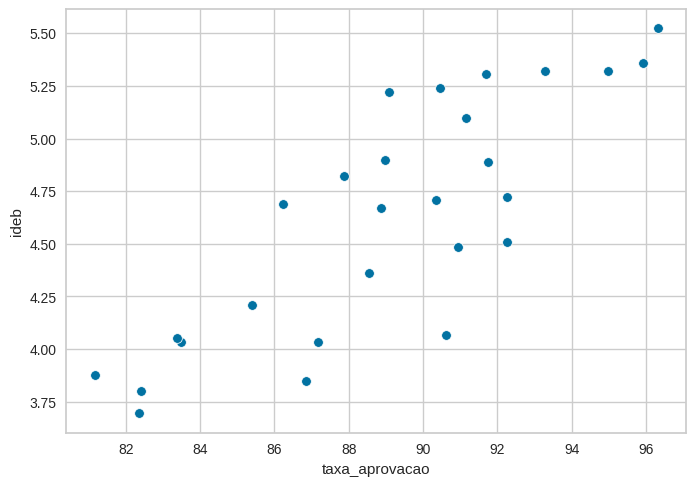

In [50]:
#Verificando dispersão com base na taxa de aprovação e no ideb
sns.scatterplot(data=df_2019, x='taxa_aprovacao', y='ideb');

In [51]:
#Função para calcular o melhor cluster
def numero_otimo_clusters(k_min, k_max):
    from sklearn.cluster import KMeans
    import math
    inercia = []

    for i in range(k_min,k_max+1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(df_scaled[['taxa_aprovacao','ideb']])
        inercia.append(kmeans.inertia_)
    
    x0, y0 = k_min, inercia[0]
    x1, y1 = k_max, inercia[len(inercia)-1]

    distancias = []
    for i in range(len(inercia)):
        x = i+k_min
        y = inercia[i]
        numerador = abs( (y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0 )
        denominador = math.sqrt( (y1 - y0)**2 + (x1 - x0)**2 )
        distancias.append(numerador/denominador)
    return distancias.index(max(distancias)) + 2, inercia

# calculando a quantidade ótima de clusters
k_otimo, inercia = numero_otimo_clusters(2,10)

print('Número otimizado de clusters: ' + str(k_otimo))

Número otimizado de clusters: 4


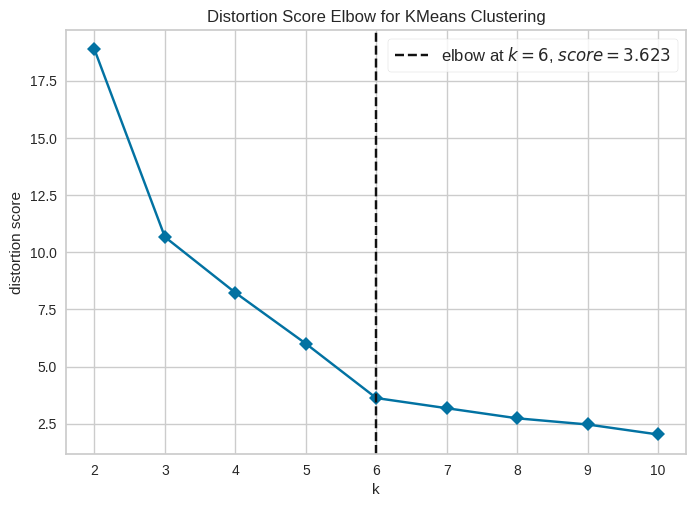

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init='auto'), timings=False)

In [52]:
#Verificando o melhor cluster
kelbow_visualizer(KMeans(n_init = "auto"), df_scaled[['taxa_aprovacao','ideb']], k=10, timings=False)

### Atividade 5: Use o método da silhueta para encontrar um valor adequado de k

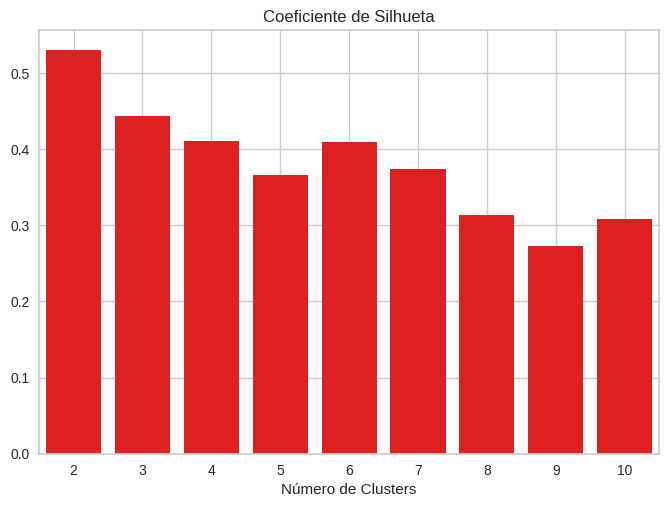

In [53]:
#Usando o método silhueta para achar o melhor cluster
silhueta = []
k_min = 2
k_max = 10
n = [i for i in range(k_min, k_max+1)]

for i in range(k_min,k_max+1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(df_scaled[['taxa_aprovacao','ideb']])
    silhueta.append(silhouette_score(df_scaled[['taxa_aprovacao','ideb']],
                                     kmeans.labels_,
                                     metric='euclidean'))

sns.barplot(x=n, y=silhueta, color='red')
plt.title('Coeficiente de Silhueta')
plt.xlabel('Número de Clusters')
plt.grid(True)

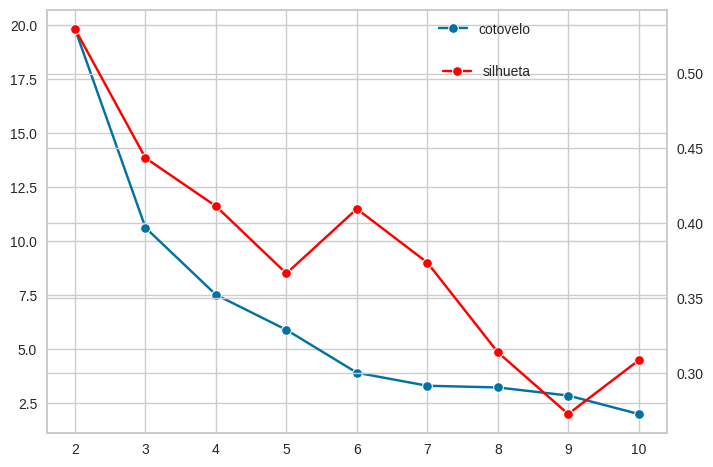

In [54]:
#Comparando o Cotovelo com a Silhueta
fig, ax = plt.subplots()
sns.lineplot(x=range(k_min,k_max+1), y=inercia, marker='o')
plt.legend(labels=["cotovelo"], bbox_to_anchor=(0.8, 1), loc='upper right')
ax2 = ax.twinx()
sns.lineplot(x=range(k_min,k_max+1), y=silhueta, marker='o', color='red')
plt.legend(labels=["silhueta"], bbox_to_anchor=(0.8, 0.9), loc='upper right');

### Atividade 6: Faça a clusterização com o valor escolhido para k.

In [55]:
#Testando com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')

kmeans.fit(df_scaled[['taxa_aprovacao','ideb']])

KMeans(n_clusters=4, n_init='auto', random_state=42)

In [56]:
#Criando a coluna grupos e colocando o resultado do kmeans
df_scaled['grupos'] = kmeans.labels_.tolist()
df_scaled.head()

,ano,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb,sigla_uf,grupos
0,0.0,-0.042238,0.080568,-0.016633,0.092154,AC,0
1,0.0,0.792119,-0.437297,-0.532115,-0.201424,AL,0
2,0.0,-0.456094,-1.474477,-1.443512,-1.063297,AM,1
3,0.0,-1.635997,-1.889406,-1.752188,-1.674063,AP,3
4,0.0,-1.358925,-0.714182,-0.626634,-1.060175,BA,3


In [57]:
#Criando a coluna grupos e colocando o resultado do kmeans
df_2019['grupos'] = kmeans.labels_.tolist()
df_2019.head(10)

,sigla_uf,ano,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb,grupos
0,AC,2019.0,88.857971,245.253478,237.995942,4.671739,0
1,AL,2019.0,92.258013,237.883189,231.412708,4.509295,0
2,AM,2019.0,87.171490,223.121965,219.773218,4.032397,1
3,AP,2019.0,82.363333,217.216667,215.831111,3.694444,3
4,BA,2019.0,83.492417,233.942537,230.205596,4.034125,3
5,CE,2019.0,94.970804,259.397187,254.290339,5.318929,2
6,DF,2019.0,88.983333,256.365000,252.218333,4.900000,0
7,ES,2019.0,91.693525,265.574820,255.552122,5.305036,2
8,GO,2019.0,95.924574,257.356514,251.849397,5.357471,2
9,MA,2019.0,90.631444,225.296995,223.669534,4.067158,1


### Atividade 7: Faça um gráfico de dispersão destacando cada grupo.

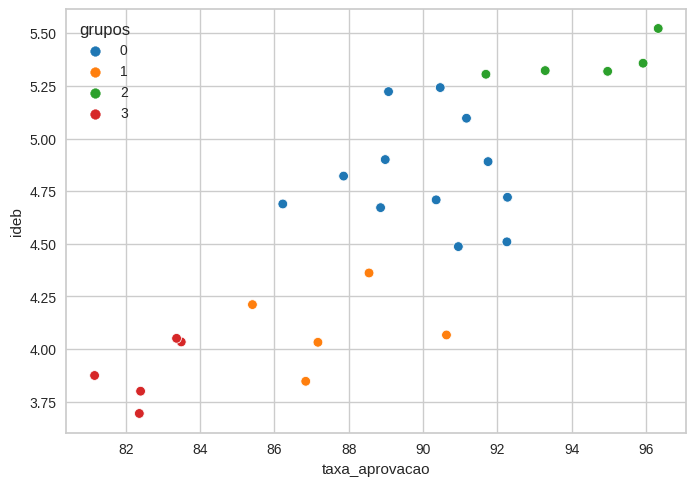

In [58]:
#Grafico de dispersão com o Cluster indicado com os grupos
sns.scatterplot(data=df_2019, x='taxa_aprovacao', y='ideb', hue='grupos', palette='tab10');

### Atividade 8: Quais são os estados de cada grupo?

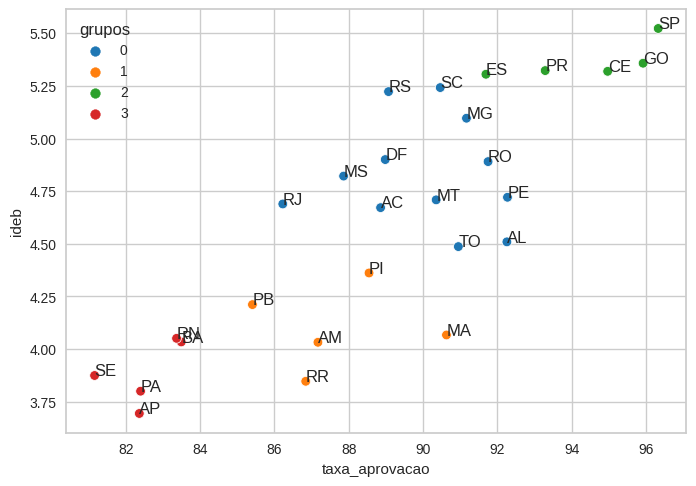

In [59]:
#Colocando as siglas dos estados para melhor visualização
sns.scatterplot(data=df_2019, x='taxa_aprovacao', y='ideb', hue='grupos', palette='tab10');

tx_aprov = df_2019['taxa_aprovacao']
ideb = df_2019['ideb']

for i, estado in enumerate(df_2019['sigla_uf']):
    plt.annotate(estado, (tx_aprov[i],ideb[i]));

### Atividade 9: Faça um boxplot para comparar os valores das variáveis por grupo.

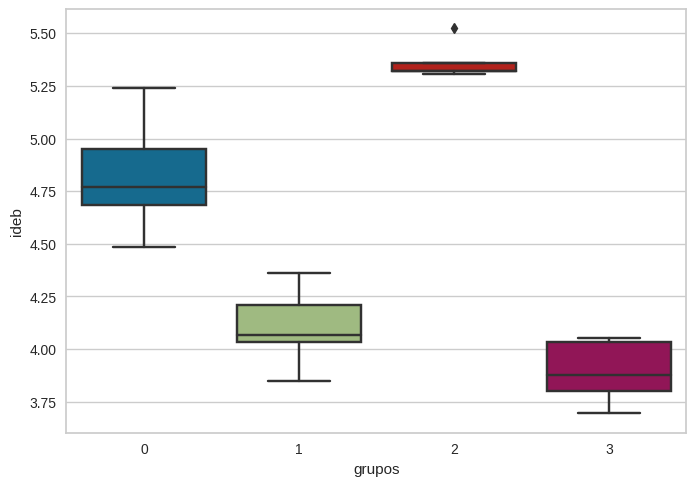

In [60]:
#Fazendo um boxplot para comparar os grupos com base no ideb
sns.boxplot(data=df_2019, x='grupos', y='ideb');

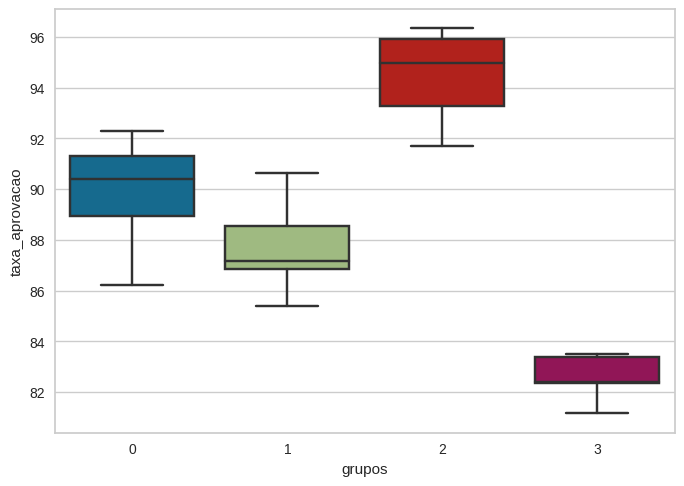

In [61]:
#Fazendo um boxplot para comparar os grupos com base na taxa de aprovação
sns.boxplot(data=df_2019, x='grupos', y='taxa_aprovacao');

### Atividade 10: Podemos afirmar, estatisticamente, que os grupos são distintos? Isto é, os dados foram adequadamente clusterizados?

In [62]:
#Montando os grupos
df_2019_0 = df_2019[df_2019['grupos']==0]
df_2019_1 = df_2019[df_2019['grupos']==1]
df_2019_2 = df_2019[df_2019['grupos']==2]
df_2019_3 = df_2019[df_2019['grupos']==3]

In [63]:
#Fazendo uma ANOVA para testar os grupos com o ideb
f_oneway(df_2019_0['ideb'],df_2019_1['ideb'],df_2019_2['ideb'],df_2019_3['ideb'])

F_onewayResult(statistic=57.57684464569191, pvalue=7.542508219427153e-11)

In [64]:
#Verificando quais grupos são rejeitados
print(pairwise_tukeyhsd(endog=df_2019['ideb'], groups=df_2019['grupos'], alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -0.726    0.0 -1.0287 -0.4233   True
     0      2   0.5353 0.0003  0.2326   0.838   True
     0      3   -0.939    0.0 -1.2417 -0.6363   True
     1      2   1.2613    0.0  0.9016   1.621   True
     1      3   -0.213 0.3778 -0.5727  0.1467  False
     2      3  -1.4743    0.0  -1.834 -1.1146   True
----------------------------------------------------


In [65]:
#Fazendo uma ANOVA para testar os grupos com a taxa de aprovação
f_oneway(df_2019_0['taxa_aprovacao'],df_2019_1['taxa_aprovacao'],df_2019_2['taxa_aprovacao'],df_2019_3['taxa_aprovacao'])

F_onewayResult(statistic=40.06478721612645, pvalue=2.6826131117684068e-09)

In [66]:
print(pairwise_tukeyhsd(endog=df_2019['taxa_aprovacao'], groups=df_2019['grupos'], alpha=0.05))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -2.2983 0.0974  -4.9048  0.3082  False
     0      2   4.4234 0.0005   1.8169  7.0299   True
     0      3  -7.4631    0.0 -10.0696 -4.8566   True
     1      2   6.7217    0.0   3.6247  9.8187   True
     1      3  -5.1647 0.0007  -8.2617 -2.0678   True
     2      3 -11.8864    0.0 -14.9834 -8.7895   True
-----------------------------------------------------


**RESPOSTA**: Podemos afirmar que há diferença significativa, pois o valor p é inferior a 0,05 para pelo menos uma comparação em cada uma das variáveis analisadas.

### Atividade 11: Faça a clusterização com outro valor para k.

In [67]:
#Fazendo com 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')

kmeans.fit(df_scaled[['taxa_aprovacao','ideb']])

KMeans(n_clusters=6, n_init='auto', random_state=42)

In [73]:
#Criando a coluna com 6 grupos e colocando o resultado do kmeans
df_2019['grupos_K6'] = kmeans.labels_.tolist()
df_2019.head()

,sigla_uf,ano,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb,grupos,grupos_K6
0,AC,2019.0,88.857971,245.253478,237.995942,4.671739,0,5
1,AL,2019.0,92.258013,237.883189,231.412708,4.509295,0,4
2,AM,2019.0,87.171490,223.121965,219.773218,4.032397,1,1
3,AP,2019.0,82.363333,217.216667,215.831111,3.694444,3,3
4,BA,2019.0,83.492417,233.942537,230.205596,4.034125,3,3


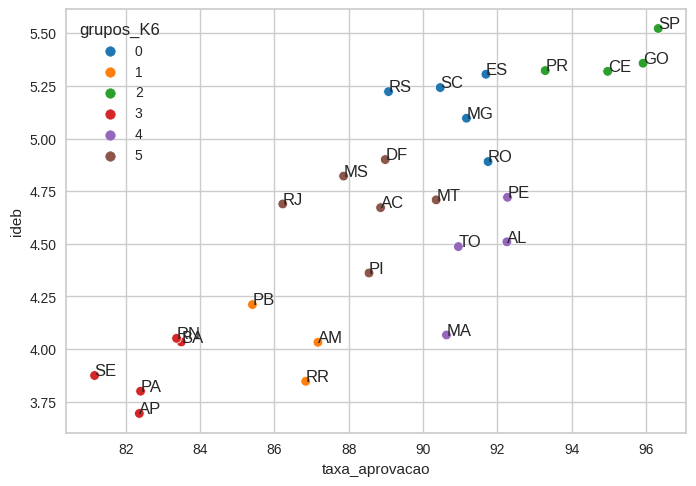

In [74]:
#Verificando dispersão com base na taxa de aprovação e no ideb para 6 clusters (Já com a sigla)
sns.scatterplot(data=df_2019, x='taxa_aprovacao', y='ideb', hue='grupos_K6', palette='tab10');

tx_aprov = df_2019['taxa_aprovacao']
ideb = df_2019['ideb']

for i, estado in enumerate(df_2019['sigla_uf']):
    plt.annotate(estado, (tx_aprov[i],ideb[i]));

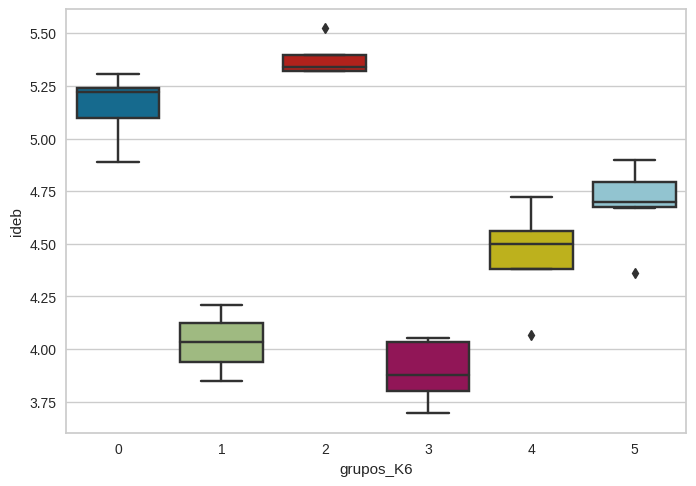

In [75]:
#Fazendo um boxplot para comparar os 6 grupos com base no ideb
sns.boxplot(data=df_2019, x='grupos_K6', y='ideb');

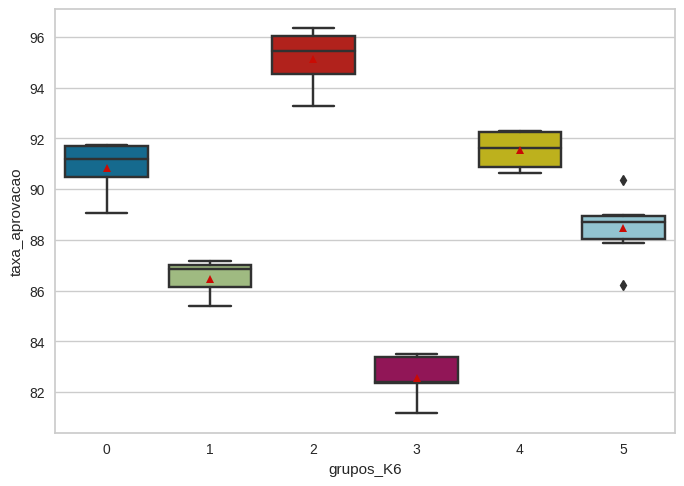

In [76]:
#Fazendo um boxplot para comparar os 6 grupos com base na taxa de aprovação
sns.boxplot(data=df_2019, x='grupos_K6', y='taxa_aprovacao', showmeans=True);

In [77]:
#Montando os grupos
df_2019_6_0 = df_2019[df_2019['grupos_K6']==0]
df_2019_6_1 = df_2019[df_2019['grupos_K6']==1]
df_2019_6_2 = df_2019[df_2019['grupos_K6']==2]
df_2019_6_3 = df_2019[df_2019['grupos_K6']==3]
df_2019_6_4 = df_2019[df_2019['grupos_K6']==4]
df_2019_6_5 = df_2019[df_2019['grupos_K6']==5]

In [78]:
#Montando a ANOVA
f_oneway(df_2019_6_0['ideb'],df_2019_6_1['ideb'],df_2019_6_2['ideb'],df_2019_6_3['ideb'],df_2019_6_4['ideb'],df_2019_6_5['ideb'])

F_onewayResult(statistic=46.09983033923752, pvalue=1.279947577601044e-10)

In [80]:
#Verificando quais grupos são rejeitados
print(pairwise_tukeyhsd(endog=df_2019['ideb'], groups=df_2019['grupos_K6'], alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -1.1209    0.0 -1.5351 -0.7067   True
     0      2   0.2291 0.4384 -0.1514  0.6096  False
     0      3  -1.2603    0.0  -1.619 -0.9016   True
     0      4  -0.7052 0.0001 -1.0857 -0.3247   True
     0      5  -0.4591 0.0049 -0.8026 -0.1157   True
     1      2     1.35    0.0  0.9168  1.7832   True
     1      3  -0.1394 0.8942 -0.5536  0.2748  False
     1      4   0.4157 0.0648 -0.0175  0.8489  False
     1      5   0.6618 0.0005  0.2607  1.0628   True
     2      3  -1.4894    0.0 -1.8699 -1.1089   True
     2      4  -0.9343    0.0 -1.3353 -0.5332   True
     2      5  -0.6882 0.0001 -1.0543 -0.3221   True
     3      4   0.5551  0.002  0.1746  0.9356   True
     3      5   0.8012    0.0  0.4577  1.1446   True
     4      5   0.2461 0.3234   -0.12  0.6122  False
----------------------------------------------

### Atividade 12: Qual dos dois valores testados para k seria mais adequado?

**RESPOSTA**: Ambos os valores do teste mostram uma diferença estatística entre os grupos, cabendo ao analista definir qual é mais significativo em determinadas circunstâncias.

### Atividade 13: (Para refletir) Como poderíamos fazer a clusterização e visualizar os grupos se tivessemos que usar mais de duas variáveis?

Dica: Pesquise sobre Redução de Dimensionalidade, é um assunto bem divertido!

**RESPOSTA**: Podemos aplicar técnicas de redução de dimensionalidade para identificar as variáveis ​​mais importantes e eliminar variáveis ​​altamente correlacionadas (em última análise, redundantes para o modelo). Isso reduzirá o número de variáveis ​​a serem consideradas, facilitando a análise.